In [1]:
!pip install -q blueqat

## 概要
理想的な誤り訂正量子コンピュータを想定した汎用アルゴリズムの一方で、NISQ向けの変分アルゴリズムがあります。

1. 汎用 (グローバー、ショア、位相推定、量子フーリエ変換、HHL、量子サポートベクターマシン、その他)
2. 変分（VQE,QAOA）

VQEは短い量子回路を利用して、既存計算機とのハイブリッドで問題を解くアルゴリズムです。

## 固有値固有ベクトル
固有値問題を解くことで様々な問題が解けます。固有値を$E_0$、固有ベクトルを$\mid \psi \rangle$としたとき、

$$
H \mid \psi \rangle = E_0 \mid \psi \rangle
$$

$E_0$を求めるのが目的です。

## Z測定
$E_0$の期待値を求める際にZ測定を使います。

$$
\langle \psi \mid H \mid \psi \rangle = 
\begin{bmatrix}
\alpha^* & \beta^*
\end{bmatrix}
\begin{bmatrix}
1&0\\
0&-1
\end{bmatrix}
\begin{bmatrix}
\alpha\\
\beta
\end{bmatrix}
= |\alpha|^2 - |\beta|^2
$$

$|\alpha|^2$と$|\beta|^2$はそれぞれ、0と1のでる確率です。

## X測定、Y測定
ときたい行列が$X$を含む際には、こちらを使います。

$$
\langle \psi \mid H \mid \psi \rangle = 
\begin{bmatrix}
\alpha^* & \beta^*
\end{bmatrix}
\begin{bmatrix}
0&1\\
1&0
\end{bmatrix}
\begin{bmatrix}
\alpha\\
\beta
\end{bmatrix}
= \alpha^* \beta + \alpha \beta^*
$$

この式は直接は測定できないので、軸の回転を利用してZ測定に落とし込みます。$X=HZH$の式変形を利用します。

$$
\langle \psi \mid X \mid \psi \rangle \\
= \langle \psi \mid HZH \mid \psi \rangle\\
= \langle \psi' \mid Z \mid \psi' \rangle
$$

$Y$には、$Y = RX(-\pi/2) Z RX(\pi/2)$

$$
\langle \psi \mid Y \mid \psi \rangle \\
= \langle \psi \mid RX(-\pi/2) Z RX(\pi/2) \mid \psi \rangle\\
= \langle \psi'' \mid Z \mid \psi'' \rangle
$$

こちらは、測定の直前に対応する回転ゲートを入れればできます。

## 線形結合
問題設定となるハミルトニアン$H$はエルミート行列と呼ばれる形で渡されます。これはユニタリー行列の和の形になっているので分解できます。

$$
\langle \psi \mid aH_1 + bH_2 \mid \psi \rangle \\ = \langle \psi \mid aH_1 \mid \psi \rangle + \langle \psi \mid bH_2 \mid \psi \rangle \\ = a\langle \psi \mid H_1 \mid \psi \rangle + b\langle \psi \mid H_2 \mid \psi \rangle
$$

これを使って、例えば、

$$
H = 1.2 X_0 Z_2 + 2.5 Z_0 X_1 Y_2 - 3.4 Z_2 X_1
$$

この式の期待値は下記のように求まります。

$$
\langle \psi \mid 1.2 X_0 Z_2 + 2.5 Z_0 X_1 Y_2 - 3.4 Z_2 X_1 \mid \psi \rangle\\
= 1.2\langle \psi \mid X_0 Z_2 \mid \psi \rangle + 2.5 \langle \psi \mid Z_0 X_1 Y_2\mid \psi \rangle - 3.4 \langle \psi \mid Z_2 X_1 \mid \psi \rangle
$$

## 量子変分原理
どのような状態ベクトルにおいても、期待値は下記を満たします。

$$
\langle \psi (\theta) \mid H \mid \psi (\theta) \rangle \geq E_0
$$

VQEではこの原理を利用し、ベクトルをランダムからスタートし、既存計算機の最適化アルゴリズムを利用し、最小値を探していきます。

## Ansatz(アンザッツ)
最小値を効率的に探すための量子回路をAnsatzと呼びます。量子化学や組合せ最適化問題にはそれぞれのAnsatzがあります。今回は簡単な問題で、Ansatzを適当なもので見てみます。問題設定を適当に置きます。

In [4]:
from blueqat.pauli import X, Y, Z, I

h = 1.23 * I - 4.56 * X(0) + 2.45 * Y(0) + 2.34 * Z(0)
h.to_matrix()

array([[ 3.57+0.j  , -4.56-2.45j],
       [-4.56+2.45j, -1.11+0.j  ]])

今回は1量子ビットだけ使う問題なので、下記のように2つの角度を使ってAnsatzを置きます。

$$
RZ(b)RX(a)
$$

## 手順

1. 回転ゲートの角度をパラメータにしてAnsatzを作ります。（量子）
2. 実行の結果から次を計算します。 $\langle \psi (\theta) \mid H \mid \psi (\theta) \rangle$ (古典)
3. 次の角度パラメータを試します。

In [5]:
import numpy as np
from blueqat import Circuit
from blueqat.pauli import X, Y, Z, I
from blueqat.vqe import AnsatzBase, Vqe

class OneQubitAnsatz(AnsatzBase):
    def __init__(self, hamiltonian):
        super().__init__(hamiltonian.to_expr(), 2)
        self.step = 1

    def get_circuit(self, params):
        a, b = params
        return Circuit().rx(a)[0].rz(b)[0]

# hamiltonian
h = 1.23 * I - 4.56 * X(0) + 2.45 * Y(0) + 2.34 * Z(0)
runner = Vqe(OneQubitAnsatz(h))
result = runner.run()

print('Result by VQE')
print(runner.ansatz.get_energy(result.circuit, runner.sampler))

# This is for check
mat = h.to_matrix()
print('Result by numpy')
print(np.linalg.eigh(mat)[0][0])

Result by VQE
-4.4507992838702055
Result by numpy
-4.450818602983201


これがVQEです。例題を2つやってみます。

## 量子化学計算
UCCと呼ばれる理論によってAnsatzが与えられます。追加のインストールをして水素分子の最小エネルギーの計算を試してみます。

In [6]:
!pip install -q openfermionblueqat openfermion

## コード

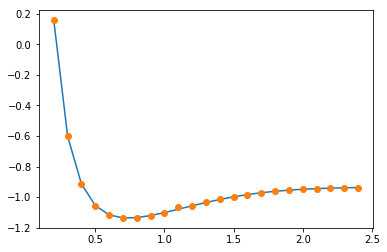

In [7]:
from blueqat import *
from openfermion import *
from openfermionblueqat import*
import numpy as np

# return the data prepared in openfermion
def get_molecule(bond_len):
  geometry = [('H',(0.,0.,0.)),('H',(0.,0.,bond_len))]

  description = format(bond_len)
  molecule = MolecularData(geometry, "sto-3g",1,description=description)

  molecule.load()
  return molecule

#array to put the result in
x = [];e=[];fullci=[]

# bond length of hydrogen atom from 0.2 to 2.5
for bond_len in np.arange(0.2,2.5,0.1):
  m = get_molecule("{:.2}".format(bond_len))
  
  #comverting hamiltonian two times on chemistry theory
  h = bravyi_kitaev(get_fermion_operator(m.get_molecular_hamiltonian()))
  
  #put the hamiltonian into UCCansatz
  runner = vqe.Vqe(UCCAnsatz(h,6,Circuit().x[0]))
  result = runner.run()
  x.append(bond_len)
  e.append(runner.ansatz.get_energy(result.circuit,runner.sampler))
  fullci.append(m.fci_energy)

#draw
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x,fullci)
plt.plot(x,e,"o")

## 簡単なチェック

原子間距離が0.4の例題をみてみます。

```python
m = get_molecule(0.4)
m.get_molecular_hamiltonian()
```

準備されたものからハミルトニアンを見てみます。

```python
() 1.322943021475
((0, 1), (0, 0)) -1.4820918858979102
((1, 1), (1, 0)) -1.4820918858979102
((2, 1), (2, 0)) -0.1187350527865787
((3, 1), (3, 0)) -0.1187350527865787
((0, 1), (0, 1), (0, 0), (0, 0)) 0.36843967630348756
((0, 1), (0, 1), (2, 0), (2, 0)) 0.08225771204699692
((0, 1), (1, 1), (1, 0), (0, 0)) 0.36843967630348756
((0, 1), (1, 1), (3, 0), (2, 0)) 0.08225771204699692
((0, 1), (2, 1), (0, 0), (2, 0)) 0.082257712046997
((0, 1), (2, 1), (2, 0), (0, 0)) 0.3626667179796745
((0, 1), (3, 1), (1, 0), (2, 0)) 0.082257712046997
((0, 1), (3, 1), (3, 0), (0, 0)) 0.3626667179796745
((1, 1), (0, 1), (0, 0), (1, 0)) 0.36843967630348756
((1, 1), (0, 1), (2, 0), (3, 0)) 0.08225771204699692
((1, 1), (1, 1), (1, 0), (1, 0)) 0.36843967630348756
((1, 1), (1, 1), (3, 0), (3, 0)) 0.08225771204699692
((1, 1), (2, 1), (0, 0), (3, 0)) 0.082257712046997
((1, 1), (2, 1), (2, 0), (1, 0)) 0.3626667179796745
((1, 1), (3, 1), (1, 0), (3, 0)) 0.082257712046997
((1, 1), (3, 1), (3, 0), (1, 0)) 0.3626667179796745
((2, 1), (0, 1), (0, 0), (2, 0)) 0.36266671797967454
((2, 1), (0, 1), (2, 0), (0, 0)) 0.08225771204699726
((2, 1), (1, 1), (1, 0), (2, 0)) 0.36266671797967454
((2, 1), (1, 1), (3, 0), (0, 0)) 0.08225771204699726
((2, 1), (2, 1), (0, 0), (0, 0)) 0.08225771204699728
((2, 1), (2, 1), (2, 0), (2, 0)) 0.38272169831413727
((2, 1), (3, 1), (1, 0), (0, 0)) 0.08225771204699728
((2, 1), (3, 1), (3, 0), (2, 0)) 0.38272169831413727
((3, 1), (0, 1), (0, 0), (3, 0)) 0.36266671797967454
((3, 1), (0, 1), (2, 0), (1, 0)) 0.08225771204699726
((3, 1), (1, 1), (1, 0), (3, 0)) 0.36266671797967454
((3, 1), (1, 1), (3, 0), (1, 0)) 0.08225771204699726
((3, 1), (2, 1), (0, 0), (1, 0)) 0.08225771204699728
((3, 1), (2, 1), (2, 0), (3, 0)) 0.38272169831413727
((3, 1), (3, 1), (1, 0), (1, 0)) 0.08225771204699728
((3, 1), (3, 1), (3, 0), (3, 0)) 0.38272169831413727
```

これは私たちの知っている形のハミルトニアンではないので、変換を利用して解ける形に持っていきます。

```python
h = bravyi_kitaev(get_fermion_operator(m.get_molecular_hamiltonian()))
```

このように自動変換されました。

```python
print(h)

(0.7407724940116754+0j)*I + (0.23528824284103544+0j)*Z[0] + (0.23528824284103542+0j)*Z[0]*Z[1] + (-0.45353118471995524+0j)*Z[2] + (-0.45353118471995524+0j)*Z[1]*Z[2]*Z[3] + (0.18421983815174378+0j)*Z[1] + (0.041128856023498556+0j)*Y[0]*Z[1]*Y[2]*Z[3] + (0.041128856023498556+0j)*X[0]*Z[1]*X[2] + (0.041128856023498556+0j)*X[0]*Z[1]*X[2]*Z[3] + (0.041128856023498556+0j)*Y[0]*Z[1]*Y[2] + (0.14020450296633868+0j)*Z[0]*Z[2] + (0.18133335898983727+0j)*Z[0]*Z[1]*Z[2]*Z[3] + (0.18133335898983727+0j)*Z[0]*Z[1]*Z[2] + (0.14020450296633868+0j)*Z[0]*Z[2]*Z[3] + (0.19136084915706864+0j)*Z[1]*Z[3]
```

これはXやYなどで書かれているので、量子コンピュータで解けます。AnsatzはUCC理論に基づいて作られますが、openfermionblueqatに搭載されているものを使ってみます。

```python
runner = vqe.Vqe(UCCAnsatz(h,2,Circuit().x[0]))
result = runner.run(verbose = True)
```

あとは、自動的に解かれます。


```python
params: [0.00803084 0.88310007] val: -0.3685674394653079
params: [0.00803084 0.88310007] val: -0.3685674394653079

...
        
params: [-0.0024937  -0.00256402] val: -0.9043519838381495
params: [-0.0024937  -0.16023561] val: -0.885812805585636
```

原子間距離0.4の時の最小値はこのように計算されました。

```python
runner.ansatz.get_energy(result.circuit,runner.sampler)

-0.9043519838381495
```

## 組合せ最適化問題
VQEで組合せ最適化を解くこともできます。やってみます。ハミルトニアンは自分で作りますが、ルールはZ演算子を使うということです。やってみましょう。

```python
h = -Z(0) - Z(0)*Z(1)
```

Zの後ろは量子ビットの通し番号です。Z(0)の前の数字はバイアス、Z(0) * Z(1)の前の数字はウェイトです。

Zは期待値として+1か-1をとります。この組合せで答えを出します。


Z(0) | Z(1) | h
--:|:----:|:--
-1|-1|0
-1|1|2
1|-1|0
1|1|-2

VQEでZ(0)=Z(1)=1 の時に、hの最小値-2を計算で探します。Ansatzは適当に、

```python
Circuit().ry[a].ry[b].cx[0,1]
```

でやってみます。

In [12]:
import numpy as np
from blueqat import Circuit
from blueqat.pauli import X, Y, Z, I
from blueqat.vqe import AnsatzBase, Vqe

class OneQubitAnsatz(AnsatzBase):
    def __init__(self, hamiltonian):
        super().__init__(hamiltonian.to_expr(), 2)
        self.step = 1

    def get_circuit(self, params):
        a, b = params
        return Circuit().ry(a)[0].ry(b)[1].cx[0,1]

# Hamiltonian
h = -Z(0) - Z(0)*Z(1)
runner = Vqe(OneQubitAnsatz(h))
result = runner.run()

print('Result by VQE')
print(runner.ansatz.get_energy(result.circuit, runner.sampler))

Result by VQE
-1.9999967180044036


例えばこの問題は、下記の設定をしたmaxcut問題と同じです。このように組合せ最適化問題が解けました。

1. Z(0)をアリス、Z(1)をボブとする
2. アリスはグループ1に属する(バイアス設定)
3. ボブはアリスと同じグループに属する(ウェイト設定)

## QUBO
Zの期待値は-1か+1でしたが、産業界では0と1を使うことが多いので、Zの式を01のバイナリ値に変換したのがQUBOです。

$$
q = \frac{Z + 1}{2}
$$

$0^2=0$ や $1^2=1$ などの便利なルールが使えます。ハミルトニアンは下記のように自動的に変換できます。

```python
h = -Z(0) - Z(0)*Z(1)
```

を

```python
h = -(2*q(0)-1)-(2*q(0)-1)*(2*q(1)-1) = 2*q(1)-4*q(0)*q(1)
```

これを解きます。

In [16]:
import numpy as np
from blueqat import Circuit
from blueqat.pauli import X, Y, Z, I
from blueqat.pauli import qubo_bit as q
from blueqat.vqe import AnsatzBase, Vqe

class QubitAnsatz(AnsatzBase):
    def __init__(self, hamiltonian):
        super().__init__(hamiltonian, 2)
        self.step = 1

    def get_circuit(self, params):
        a, b = params
        return Circuit().ry(a)[0].ry(b)[1].cx[0,1]

h = 2*q(1)-4*q(0)*q(1)
runner = Vqe(QubitAnsatz(h))
result = runner.run()

print('Result by VQE')
print(runner.ansatz.get_energy(result.circuit, runner.sampler))

Result by VQE
-1.9912118061203703
